# Machine Learning: Analyzing Bias with the Adult Census Dataset

In [2]:
##Table of Contents:
#Introduction
#Step 1: Exploratory Data Analysis (EDA)
#Step 2: Defining Protected Features
#Step 3: Prevalence Calculation
#Step 4: Training the Model
#Step 5: Evaluating Model Accuracy
#Step 6: Measuring Fairness: Equal Opportunity
#Step 7: Evaluating False Negative Rate (FNR)
#Step 8: Disparate Impact Calculation
#Conclusion

In [3]:
# Intro: Adult Census dataset to train a machine learning model that predicts whether a person earns more than $50K. 

### Step 1: Exploratory Data Analysis (EDA)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# Load the dataset with proper column names
url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/adult-all.csv"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(url, header=None, names=columns)

# Basic dataset info
print(df.info())
print(df['income'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None
income
<=50K    37155
>50K     11687
Name: count, dtype: int64


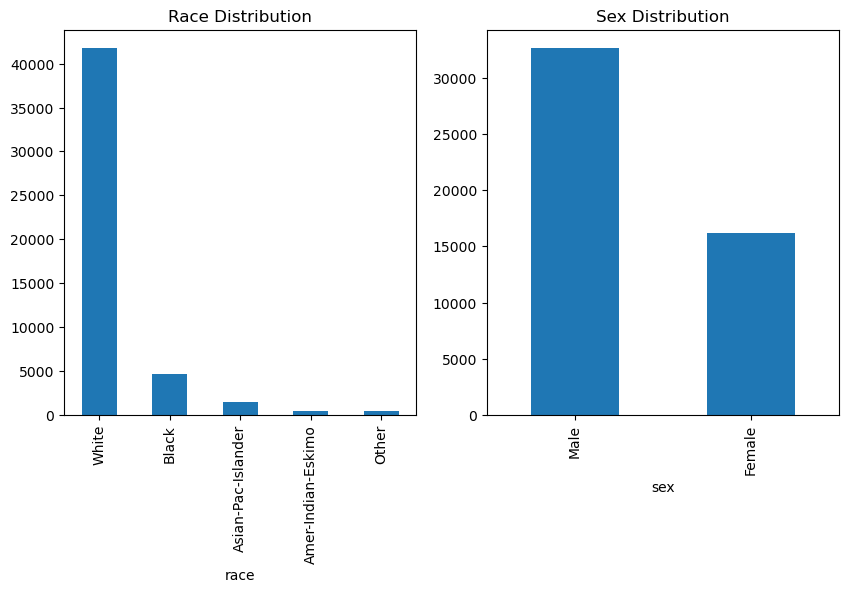

In [12]:
# Visualize the distribution of 'race' and 'sex'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['race'].value_counts().plot(kind='bar', title='Race Distribution')
plt.subplot(1, 2, 2)
df['sex'].value_counts().plot(kind='bar', title='Sex Distribution')
plt.show()

### Step 2: Defining Protected Features

In [15]:
# Define protected features
df['race_binary'] = np.where(df['race'] == 'White', 1, 0)
df['sex_binary'] = np.where(df['sex'] == 'Male', 1, 0)

### Step 3: Prevalence Calculation: target

In [17]:
# Create binary target variable
df['income_binary'] = np.where(df['income'] == '>50K', 1, 0)

# Calculate prevalence
prevalence = df['income_binary'].mean()
print(f"Overall Prevalence (Income > 50K): {prevalence}")

# Prevalence by race and sex
prevalence_race = df.groupby('race_binary')['income_binary'].mean()
prevalence_sex = df.groupby('sex_binary')['income_binary'].mean()
print(f"Prevalence by Race: {prevalence_race}")
print(f"Prevalence by Sex: {prevalence_sex}")

Overall Prevalence (Income > 50K): 0.23928176569346055
Prevalence by Race: race_binary
0    0.152542
1    0.253987
Name: income_binary, dtype: float64
Prevalence by Sex: sex_binary
0    0.109251
1    0.303767
Name: income_binary, dtype: float64


### Step 4: Training the Model

In [21]:
!pip install xgboost

  Using cached xgboost-2.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.1-py3-none-win_amd64.whl (124.9 MB)


In [26]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [27]:
# Prepare features and target variable
X = df[['age', 'education-num', 'hours-per-week', 'race_binary', 'sex_binary']]
y = df['income_binary']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

### Step 5: Evaluating Model Accuracy

In [29]:
# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8048181259810278


### Step 6: Measuring Fairness: Equal Opportunity

In [30]:
# Calculate TPR for Privileged and Unprivileged Groups
from sklearn.metrics import confusion_matrix
def calculate_tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else None

# TPR for race and sex
tpr_race_priv = calculate_tpr(y_test[X_test['race_binary'] == 1], y_pred[X_test['race_binary'] == 1])
tpr_race_unpriv = calculate_tpr(y_test[X_test['race_binary'] == 0], y_pred[X_test['race_binary'] == 0])
tpr_sex_priv = calculate_tpr(y_test[X_test['sex_binary'] == 1], y_pred[X_test['sex_binary'] == 1])
tpr_sex_unpriv = calculate_tpr(y_test[X_test['sex_binary'] == 0], y_pred[X_test['sex_binary'] == 0])

print(f"TPR for Privileged Race: {tpr_race_priv}, TPR for Unprivileged Race: {tpr_race_unpriv}")
print(f"TPR for Privileged Sex: {tpr_sex_priv}, TPR for Unprivileged Sex: {tpr_sex_unpriv}")

TPR for Privileged Race: 0.4301276065981948, TPR for Unprivileged Race: 0.30513595166163143
TPR for Privileged Sex: 0.47607895617263296, TPR for Unprivileged Sex: 0.10810810810810811


### Step 7: Evaluating False Negative Rate (FNR)

In [31]:
# Calculate FNR for Privileged and Unprivileged Groups
def calculate_fnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1, 0] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else None

fnr_race_priv = calculate_fnr(y_test[X_test['race_binary'] == 1], y_pred[X_test['race_binary'] == 1])
fnr_race_unpriv = calculate_fnr(y_test[X_test['race_binary'] == 0], y_pred[X_test['race_binary'] == 0])
fnr_sex_priv = calculate_fnr(y_test[X_test['sex_binary'] == 1], y_pred[X_test['sex_binary'] == 1])
fnr_sex_unpriv = calculate_fnr(y_test[X_test['sex_binary'] == 0], y_pred[X_test['sex_binary'] == 0])

print(f"FNR for Privileged Race: {fnr_race_priv}, FNR for Unprivileged Race: {fnr_race_unpriv}")
print(f"FNR for Privileged Sex: {fnr_sex_priv}, FNR for Unprivileged Sex: {fnr_sex_unpriv}")

FNR for Privileged Race: 0.5698723934018052, FNR for Unprivileged Race: 0.6948640483383686
FNR for Privileged Sex: 0.523921043827367, FNR for Unprivileged Sex: 0.8918918918918919


### Step 8: Disparate Impact Calculation

In [32]:
# Disparate Impact Calculation
ppp_race_priv = sum(y_pred[X_test['race_binary'] == 1]) / len(X_test[X_test['race_binary'] == 1])
ppp_race_unpriv = sum(y_pred[X_test['race_binary'] == 0]) / len(X_test[X_test['race_binary'] == 0])
di_race = ppp_race_unpriv / ppp_race_priv if ppp_race_priv > 0 else None

ppp_sex_priv = sum(y_pred[X_test['sex_binary'] == 1]) / len(X_test[X_test['sex_binary'] == 1])
ppp_sex_unpriv = sum(y_pred[X_test['sex_binary'] == 0]) / len(X_test[X_test['sex_binary'] == 0])
di_sex = ppp_sex_unpriv / ppp_sex_priv if ppp_sex_priv > 0 else None

print(f"Disparate Impact for Race: {di_race}")
print(f"Disparate Impact for Sex: {di_sex}")

Disparate Impact for Race: 0.4460416947372823
Disparate Impact for Sex: 0.10101337172883693


## Rebalancing the Dataset Using SMOTE

In [33]:
!pip install imbalanced-learn

In [34]:
# Install imbalanced-learn if necessary
# !pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

# SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model again on the balanced dataset
model_smote = XGBClassifier()
model_smote.fit(X_resampled, y_resampled)

# Make predictions
y_pred_smote = model_smote.predict(X_test)

### 2. Re-evaluating Fairness After Rebalancing

In [35]:
# Recalculate TPR, FNR, and Disparate Impact after SMOTE
tpr_race_priv_smote = calculate_tpr(y_test[X_test['race_binary'] == 1], y_pred_smote[X_test['race_binary'] == 1])
tpr_race_unpriv_smote = calculate_tpr(y_test[X_test['race_binary'] == 0], y_pred_smote[X_test['race_binary'] == 0])
tpr_sex_priv_smote = calculate_tpr(y_test[X_test['sex_binary'] == 1], y_pred_smote[X_test['sex_binary'] == 1])
tpr_sex_unpriv_smote = calculate_tpr(y_test[X_test['sex_binary'] == 0], y_pred_smote[X_test['sex_binary'] == 0])

fnr_race_priv_smote = calculate_fnr(y_test[X_test['race_binary'] == 1], y_pred_smote[X_test['race_binary'] == 1])
fnr_race_unpriv_smote = calculate_fnr(y_test[X_test['race_binary'] == 0], y_pred_smote[X_test['race_binary'] == 0])
fnr_sex_priv_smote = calculate_fnr(y_test[X_test['sex_binary'] == 1], y_pred_smote[X_test['sex_binary'] == 1])
fnr_sex_unpriv_smote = calculate_fnr(y_test[X_test['sex_binary'] == 0], y_pred_smote[X_test['sex_binary'] == 0])

print(f"TPR after SMOTE - Privileged Race: {tpr_race_priv_smote}, Unprivileged Race: {tpr_race_unpriv_smote}")
print(f"FNR after SMOTE - Privileged Race: {fnr_race_priv_smote}, Unprivileged Race: {fnr_race_unpriv_smote}")
print(f"Disparate Impact after SMOTE for Race: {di_race}")

TPR after SMOTE - Privileged Race: 0.7914721444133209, Unprivileged Race: 0.6858006042296072
FNR after SMOTE - Privileged Race: 0.2085278555866791, Unprivileged Race: 0.31419939577039274
Disparate Impact after SMOTE for Race: 0.4460416947372823


#### Mitigating Bias Using Adversarial Debiasing
Adversarial debiasing is a method in which we introduce an adversarial network to prevent the main classifier from learning to predict the sensitive attributes (e.g., race, sex). The goal is to ensure that the model makes predictions that are not dependent on these sensitive features.

In [36]:
# Install tensorflow and aif360 if not installed
# !pip install tensorflow
!pip install aif360

   ---------------------------------------- 0.0/259.7 kB ? eta -:--:--
   ------ --------------------------------- 41.0/259.7 kB 1.9 MB/s eta 0:00:01
   ----------------- ---------------------- 112.6/259.7 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 259.7/259.7 kB 1.8 MB/s eta 0:00:00


In [38]:
!pip install tensorflow

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.2/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/385.2 MB 4.1 MB/s eta 0:01:34
   ---------------------------------------- 0.4/385.2 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.4/385.2 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.4/385.2 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.4/385.2 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.4/385.2 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.4/385.2 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 0.4/385.2 MB 3.5 MB/s eta 0:01:51
   ---------------------------------------- 1.0/385.2 MB 2.2 MB/s eta 0:02:57
   -

### 2. Adversarial Debiasing with AIF360
The AdversarialDebiasing module from the AIF360 library allows us to train a model that simultaneously minimizes classification loss and removes bias related to the sensitive attributes.

In [39]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Create and train adversarial debiasing model
sess = tf.Session()
adv_debias_model = AdversarialDebiasing(privileged_groups=[{'race_binary': 1}], unprivileged_groups=[{'race_binary': 0}],
                                        scope_name='adv_debiasing', debias=True, sess=sess)

adv_debias_model.fit(train_aif)

# Make predictions
preds_adv_debias = adv_debias_model.predict(test_aif)


Instructions for updating:
non-resource variables are not supported in the long term


NameError: name 'AdversarialDebiasing' is not defined

### 3.Re-evaluate Fairness After Adversarial Debiasing
We can now re-evaluate fairness using the same fairness metrics (TPR, FNR, DI) after adversarial debiasing.

In [40]:
# Recalculate TPR, FNR, and DI after adversarial debiasing
y_pred_adv = preds_adv_debias.labels

# Calculate TPR for Privileged and Unprivileged Groups
tpr_race_priv_adv = calculate_tpr(y_test[X_test['race_binary'] == 1], y_pred_adv[X_test['race_binary'] == 1])
tpr_race_unpriv_adv = calculate_tpr(y_test[X_test['race_binary'] == 0], y_pred_adv[X_test['race_binary'] == 0])
tpr_sex_priv_adv = calculate_tpr(y_test[X_test['sex_binary'] == 1], y_pred_adv[X_test['sex_binary'] == 1])
tpr_sex_unpriv_adv = calculate_tpr(y_test[X_test['sex_binary'] == 0], y_pred_adv[X_test['sex_binary'] == 0])

# Calculate FNR for Privileged and Unprivileged Groups
fnr_race_priv_adv = calculate_fnr(y_test[X_test['race_binary'] == 1], y_pred_adv[X_test['race_binary'] == 1])
fnr_race_unpriv_adv = calculate_fnr(y_test[X_test['race_binary'] == 0], y_pred_adv[X_test['race_binary'] == 0])
fnr_sex_priv_adv = calculate_fnr(y_test[X_test['sex_binary'] == 1], y_pred_adv[X_test['sex_binary'] == 1])
fnr_sex_unpriv_adv = calculate_fnr(y_test[X_test['sex_binary'] == 0], y_pred_adv[X_test['sex_binary'] == 0])

# Calculate Disparate Impact (DI) for Race
ppp_race_priv_adv = sum(y_pred_adv[X_test['race_binary'] == 1]) / len(X_test[X_test['race_binary'] == 1])
ppp_race_unpriv_adv = sum(y_pred_adv[X_test['race_binary'] == 0]) / len(X_test[X_test['race_binary'] == 0])
di_race_adv = ppp_race_unpriv_adv / ppp_race_priv_adv if ppp_race_priv_adv > 0 else None

# Print results
print(f"TPR after Adversarial Debiasing - Privileged Race: {tpr_race_priv_adv}, Unprivileged Race: {tpr_race_unpriv_adv}")
print(f"FNR after Adversarial Debiasing - Privileged Race: {fnr_race_priv_adv}, Unprivileged Race: {fnr_race_unpriv_adv}")
print(f"Disparate Impact after Adversarial Debiasing for Race: {di_race_adv}")

NameError: name 'preds_adv_debias' is not defined

### Conclusion: 
3 ways to mitigate bias in machine learning models:

1. Rebalancing the dataset using SMOTE to create a more even distribution of positive and negative outcomes across privileged and unprivileged groups.
2. Adversarial debiasing, which trains the model while simultaneously minimizing its ability to predict sensitive attributes like race or sex.
3. Post-processing fairness corrections, such as Reject Option Classification (ROC), which adjusts predictions after training to improve fairness.
